Load required modules and libraries

In [1]:
#import required modules

import os, glob, re, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

from keras import utils
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score

Get and sort testing data

In [2]:
# dir_path points towards where to find the image dataset
dir_path = "brain_tumor_dataset"
IMAGE_SHAPE = (224, 224)

random_sample = 1

# Read the folders folders
directories = os.listdir(dir_path)

files = [] 
labels = []

# Read files for each directory
for folder in directories:
    
    fileList = glob.glob(f'{dir_path}/{folder}/*')
    labels.extend([folder for _ in fileList])
    files.extend(fileList)

# One hot encoding

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = utils.to_categorical(encoded_Y,dtype ="uint8", num_classes = 2)

labels = np.array(dummy_y)

print(f"Classes are {encoder.classes_}")

# Split the data into testing, training and validation data
# As using a random sample = 1, the testing set is the same as used for the model.
x_train, x_tv, y_train, y_tv = train_test_split(files, labels, test_size=.3, random_state = random_sample)
x_test, x_val, y_test, y_val = train_test_split(x_tv, y_tv, test_size=.5, random_state = random_sample)

images = []
labels = []

print("Preparing testing data")
for file, label in zip(x_test, y_test):

    # Prepare the image
    new_file = image.load_img(file, target_size=IMAGE_SHAPE)
    img_array = image.img_to_array(new_file)
    # Append to array
    images.append(img_array)
    labels.append(label)

Classes are ['no' 'yes']
Preparing testing data


Load the classifier

In [3]:
model_A = keras.models.load_model("97%.h5")

Test the model on test data

In [4]:
temp_model = tf.keras.Model(model_A.input,model_A.layers[-2].output)
final_layers = temp_model.predict(np.stack(images))
predictions = model_A.predict(np.stack(images))
pred_array = [[0,1][np.argmax(individual_result)] for individual_result in predictions]

2/2 [==============================] - 5s 532ms/step


In [5]:
labels = [label[1] for label in y_test] # 0 if no tumour, 1 if yes tumour

initial_df = pd.DataFrame()
initial_df["class"] = labels # 0 if no tumour, 1 if there is a tumour
initial_df["image_index"] = [i for i in range(len(images))]
initial_df["confidence_class_0"] = [alpha[0] for alpha in predictions]
initial_df["confidence_class_1"] = [alpha[1] for alpha in predictions]

In [6]:
class_zero_df = initial_df[initial_df["class"] == 0] # no tumour
class_one_df = initial_df[initial_df["class"] == 1]
class_one_length = len(class_one_df)
class_zero_length = len(class_zero_df)

In [7]:
muba_df = pd.DataFrame(columns = [
                    "alpha_class_0",
                    "alpha_class_1",
                    "image_0",
                    "image_1",
                    "mixup_image",
                    "type",
                    "label",
    ])

Create mixup data

In [8]:
MUBA_ITERS = 60

# Iterate through NO tumour images
for index0, row0 in class_zero_df.iterrows():
    
    # Iterate through YES tumour images
    for index1, row1 in class_one_df.iterrows():

        for i in range(MUBA_ITERS):
            
            # Mixup images
            lam = (1/MUBA_ITERS) * np.random.rand() + ( (i) / MUBA_ITERS)
            new_img = lam * images[int(row0["image_index"])] + (1 - lam) * images[int(row1["image_index"])]

            label = 1
            if lam > 0.5:
                label = 0

            row = pd.DataFrame([({ "alpha_class_0": lam, # row 0 is multiplied by lam
                    "alpha_class_1": 1-lam,
                    "image_0": images[int(row0["image_index"])],
                    "image_1": images[int(row1["image_index"])],
                    "mixup_image": new_img,
                    "type":"mix",
                    "label":label
                    })])
            
            
            muba_df = pd.concat([muba_df, row],axis=0, ignore_index=True)



Make predictions on mixup data.

In [9]:
# Predict only on MUBA images

muba_prediction = model_A.predict(np.stack(muba_df["mixup_image"]))
muba_final_layers = temp_model.predict(np.stack(muba_df["mixup_image"]))

670/670 [==============================] - 1891s 3s/step


In [10]:
muba_prediction_proper = [[0,1][np.argmax(individual_result)] for individual_result in muba_prediction]
muba_df["argmax_pred"] = muba_prediction_proper

In [11]:
muba_df.head(1)

,alpha_class_0,alpha_class_1,image_0,image_1,mixup_image,type,label,argmax_pred
0,0.012859,0.987141,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1


Find boundary points and add them to dataframe.

In [12]:
boundary_points_df = pd.DataFrame(columns = [
                    "alpha_class_0",
                    "alpha_class_1",
                    "image_0",
                    "image_1",
                    "mixup_image",
                    "type",
                    "label",
    ])

for i in range(int((len(muba_df))/MUBA_ITERS)):

    # Create a mask to split df in to blocks of MUBA_ITERS
    mask = (muba_df.index >= MUBA_ITERS*i) & (muba_df.index < MUBA_ITERS*i + MUBA_ITERS)
    window_df = muba_df.loc[mask]

    # Find the index in which the prediction changes
    changing_pred_index = (window_df["argmax_pred"].diff()[window_df["argmax_pred"].diff() != 0].index.values)
    for index, row in window_df.iterrows():
        
        if index in changing_pred_index[1:]:
            
            row0 = window_df.loc[[index]]
            row1 = window_df.loc[[index-1]]


            alpha_class_0 = ( float(row0["alpha_class_0"]) + float(row1["alpha_class_0"])) / 2
            alpha_class_1 = 1 - alpha_class_0
            mixup_image = (alpha_class_0 * row0["image_0"] + alpha_class_1 * row0["image_1"])[index]
            

            label = 1
            if alpha_class_0 > 0.5:
                label = 0

            row = pd.DataFrame([({ "alpha_class_0":alpha_class_0,
                    "alpha_class_1": alpha_class_1,
                    "image_0": row0["image_0"],
                    "image_1": row0["image_1"],
                    "mixup_image": mixup_image,
                    "type":"boundary",
                    "label":label
                    })])
            
            boundary_points_df = pd.concat([boundary_points_df, row],axis=0, ignore_index=True)
            
            

In [13]:
boundary_prediction = model_A.predict(np.stack(boundary_points_df["mixup_image"]))
boundary_final_layers = temp_model.predict(np.stack(boundary_points_df["mixup_image"]))

12/12 [==============================] - 29s 2s/step


In [14]:
boundary_points_df.head()

,alpha_class_0,alpha_class_1,image_0,image_1,mixup_image,type,label
0,0.611112,0.388888,"37 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0...","37 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",boundary,0
1,0.702298,0.297702,"102 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0....","102 [[[2.0, 2.0, 2.0], [2.0, 2.0, 2.0], [3....","[[[0.5954049, 0.5954049, 0.5954049], [0.595404...",boundary,0
2,0.765152,0.234848,"166 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0....","166 [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1....","[[[0.23484758, 0.23484758, 0.23484758], [0.234...",boundary,0
3,0.714047,0.285953,"223 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0....","223 [[[42.0, 42.0, 42.0], [39.0, 39.0, 39.0...","[[[12.0100155, 12.0100155, 12.0100155], [11.15...",boundary,0
4,0.429681,0.570319,"266 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0....","266 [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1....","[[[0.5703186, 0.5703186, 0.5703186], [0.570318...",boundary,1


In [15]:
muba_df.head(5)

,alpha_class_0,alpha_class_1,image_0,image_1,mixup_image,type,label,argmax_pred
0,0.012859,0.987141,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1
1,0.030276,0.969724,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1
2,0.034602,0.965398,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1
3,0.056710,0.943290,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1
4,0.072669,0.927331,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1


Join the mixup data and test data together, so that t-SNE can be applied to all data at once.

In [16]:
boundary_points_df["argmax_pred"] = [[0,1][np.argmax(individual_result)] for individual_result in boundary_prediction]

In [17]:
muba_df = pd.concat([muba_df,boundary_points_df],axis=0,ignore_index=True)

In [18]:
for image,label,pred in zip(images,labels,pred_array):
    row = pd.DataFrame([({ "alpha_class_0": None, # row 0 is multiplied by lam
                    "alpha_class_1": None,
                    "image_0": None,
                    "image_1":None,
                    "mixup_image": image,
                    "type":"orig",
                    "label":label,
                    "argmax_pred":pred,
                    })])
    muba_df = pd.concat([muba_df, row],axis=0, ignore_index=True)

In [19]:
all_images = muba_df["mixup_image"]
all_final_layers = np.concatenate([muba_final_layers,boundary_final_layers, final_layers])

find Projections

In [20]:
muba_projections = TSNE(2,random_state=1).fit_transform(all_final_layers ) # 1, 

In [21]:
muba_df["projection_x"] = [x[0] for x in muba_projections]
muba_df["projection_y"] = [x[1] for x in muba_projections]

In [22]:
muba_df.head()

,alpha_class_0,alpha_class_1,image_0,image_1,mixup_image,type,label,argmax_pred,projection_x,projection_y
0,0.012859,0.987141,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,53.463840,-96.158333
1,0.030276,0.969724,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,54.240086,-94.295929
2,0.034602,0.965398,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,54.420383,-93.747993
3,0.056710,0.943290,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,55.100010,-90.867073
4,0.072669,0.927331,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,55.321739,-89.250259


Filter dataframe

In [23]:
true_images_df = muba_df[muba_df["type"] == "orig"]
mixup_images_df =  muba_df[muba_df["type"] == "mix"]
boundary_images_df = muba_df[muba_df["type"] == "boundary"]

In [24]:
min_alpha = []
for i, row in mixup_images_df.iterrows():
    if row["alpha_class_0"] < row["alpha_class_1"]:
        min_alpha.append(row["alpha_class_0"])
    else:
        min_alpha.append(row["alpha_class_1"])

mixup_images_df["min_alpha"] = min_alpha

C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_15236\2393872059.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mixup_images_df["min_alpha"] = min_alpha


In [25]:
true_class_A = true_images_df[true_images_df["label"] == 0]
true_class_B = true_images_df[true_images_df["label"] == 1]

mixup_class_A = mixup_images_df[mixup_images_df["label"] == 0]
mixup_class_B = mixup_images_df[mixup_images_df["label"] == 1]

true_errors = true_images_df[true_images_df["label"] != true_images_df["argmax_pred"]]
mixup_errors = mixup_images_df[mixup_images_df["label"] != mixup_images_df["argmax_pred"]]

error_free_true_class_A = true_class_A[true_class_A["label"] == true_class_A["argmax_pred"]]
error_free_true_class_B = true_class_B[true_class_B["label"] == true_class_B["argmax_pred"]]
error_free_mixup_class_A = mixup_class_A[mixup_class_A["label"] == mixup_class_A["argmax_pred"]]
error_free_mixup_class_B = mixup_class_B[mixup_class_B["label"] == mixup_class_B["argmax_pred"]]


Plot Projections

Text(0.5, 1.0, 't-SNE Dimension Analysis')

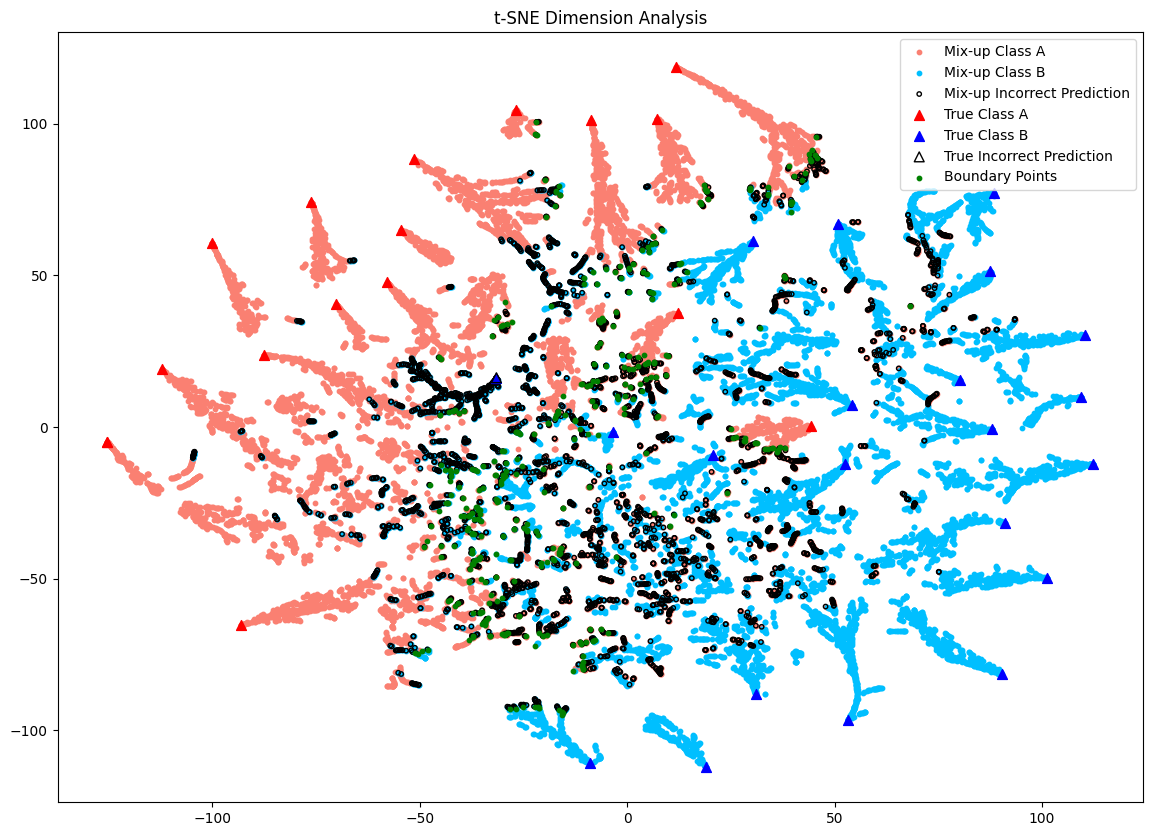

In [30]:
# Choose variables for graph
include_errors = True
colour_by_alpha = False
show_boundary_points = True
scale_errors = False

fig, ax = plt.subplots(figsize=(14, 10))

if colour_by_alpha:

    # Combine two colour maps
    colors1 = plt.cm.Reds_r(np.linspace(0., 1, 128))
    colors2 = plt.cm.Blues(np.linspace(0, 1, 128))

    # Build a new colormap
    colors = np.vstack((colors1, colors2))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

    if include_errors:
        ax.scatter(error_free_mixup_class_A["projection_x"],error_free_mixup_class_A["projection_y"],marker="o",s=10,c = error_free_mixup_class_A["alpha_class_0"],cmap = "Reds",vmin=0.5,vmax=1)
        ax.scatter(error_free_mixup_class_B["projection_x"],error_free_mixup_class_B["projection_y"],marker="o",s=10,c = error_free_mixup_class_B["alpha_class_0"],cmap = "Blues_r", label = "Mix-up",vmin=0,vmax=0.5)
        a = ax.scatter(mixup_errors["projection_x"],mixup_errors["projection_y"],marker="o",s = (mixup_errors["min_alpha"]*7)**4 if scale_errors else 10 ,c = mixup_errors["alpha_class_0"],cmap = mymap, edgecolors="black",label="Mix-up Incorrect Prediction",vmin=0,vmax=1)
    elif not include_errors:
        ax.scatter(error_free_mixup_class_A["projection_x"],error_free_mixup_class_A["projection_y"],marker="o",s=10,c = error_free_mixup_class_A["alpha_class_0"],cmap = "Reds",vmin=0.5,vmax=1)
        ax.scatter(error_free_mixup_class_B["projection_x"],error_free_mixup_class_B["projection_y"],marker="o",s=10,c = error_free_mixup_class_B["alpha_class_0"],cmap = "Blues_r", label = "Mix-up",vmin=0,vmax=0.5)
        a = ax.scatter([0],[0],s=0,vmin=0,vmax=1,c=[0.5],cmap=mymap)
    plt.colorbar(a,label = "Class A Alpha Value")

elif not colour_by_alpha:

    if include_errors:
        ax.scatter(mixup_class_A["projection_x"],mixup_class_A["projection_y"],marker="o",s=10,color = "salmon",label="Mix-up Class A")
        ax.scatter(mixup_class_B["projection_x"],mixup_class_B["projection_y"],marker="o",s=10,color = "deepskyblue",label="Mix-up Class B")
        ax.scatter(mixup_errors["projection_x"],mixup_errors["projection_y"],marker="o",s=10,color="None",edgecolors="black",label="Mix-up Incorrect Prediction")
    elif not include_errors:
        ax.scatter(error_free_mixup_class_A["projection_x"],error_free_mixup_class_A["projection_y"],marker="o",s=10,color = "salmon",label="Mix-up Class A")
        ax.scatter(error_free_mixup_class_B["projection_x"],error_free_mixup_class_B["projection_y"],marker="o",s=10,color = "deepskyblue",label="Mix-up Class B")

ax.scatter(true_class_A["projection_x"],true_class_A["projection_y"],marker="^",s=50,color="red",label="True Class A")
ax.scatter(true_class_B["projection_x"],true_class_B["projection_y"],marker="^",s=50,color="blue",label="True Class B")
ax.scatter(true_errors["projection_x"],true_errors["projection_y"],marker="^",s=50,color="None",edgecolors="black",label="True Incorrect Prediction",)

if show_boundary_points:
    ax.scatter(boundary_images_df["projection_x"],boundary_images_df["projection_y"],marker="o",s=10,color="green",label="Boundary Points")

    

ax.legend()

ax.set_title("t-SNE Dimension Analysis")


(array([ 45.,  49.,  56.,  61.,  85., 105., 154., 186., 227., 258., 410.,
        581., 498., 395., 291., 196., 138.,  85.,  39.,  11.]),
 array([7.15877579e-04, 4.71876876e-02, 9.36594976e-02, 1.40131308e-01,
        1.86603118e-01, 2.33074928e-01, 2.79546738e-01, 3.26018548e-01,
        3.72490358e-01, 4.18962168e-01, 4.65433978e-01, 5.11905788e-01,
        5.58377598e-01, 6.04849408e-01, 6.51321218e-01, 6.97793028e-01,
        7.44264838e-01, 7.90736648e-01, 8.37208458e-01, 8.83680268e-01,
        9.30152078e-01]),
 <BarContainer object of 20 artists>)

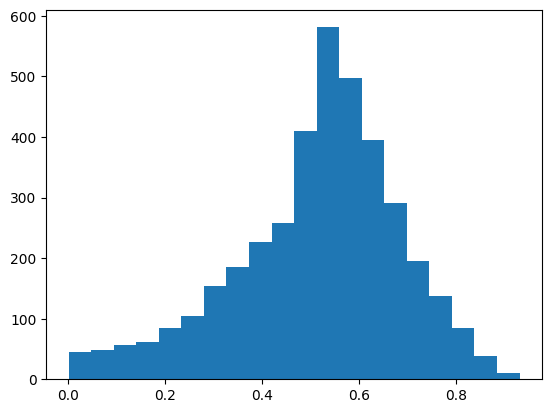

In [29]:
plt.hist(mixup_errors["alpha_class_0"],20)